# Import Libraries

In [50]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import yfinance as yf
import backtrader as bt

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Load Stock Data (using Yahoo Finance)

In [35]:
def load_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Calculating Technical Indicators for Clustering

In [4]:
def calculate_indicators(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['ATR'] = df['High'].rolling(window=14).max() - df['Low'].rolling(window=14).min()
    df['RSI'] = 100 - (100 / (1 + df['Close'].diff().rolling(window=14).mean() / df['Close'].diff().rolling(window=14).std()))
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    df.dropna(inplace=True)
    return df

# Using Hidden Markov Chains for Clustering

In [38]:
def prepare_hmm_data(df):
    features = df[['ATR', 'RSI', 'OBV', 'Close', 'Volume']].values
    return features

def apply_hmm(features, n_components=3):
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
    model.fit(features)
    hidden_states = model.predict(features)
    return hidden_states

# Plotting Results

In [45]:
def plot_stock_with_phases(df):
    plt.figure(figsize=(14, 7))
    phase_colors = {0: 'red', 1: 'green', 2: 'blue', 3:'yellow'}  # Assign colors to each phase
    df['Color'] = df['Market_Phase'].map(phase_colors)
    
    plt.plot(df.index, df['Close'], color='black', label='Close Price')
    plt.scatter(df.index, df['Close'], c=df['Color'], alpha=0.5, label='Market Phases')
    plt.title('Stock Price with Market Phases')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

def plot_volume_with_phases(df):
    plt.figure(figsize=(14, 7))
    phase_colors = {0: 'red', 1: 'green', 2: 'blue'}
    df['Color'] = df['Market_Phase'].map(phase_colors)
    
    plt.bar(df.index, df['Volume'], color=df['Color'], alpha=0.5)
    plt.title('Volume with Market Phases')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.show()

# Running Code

[*********************100%***********************]  1 of 1 completed


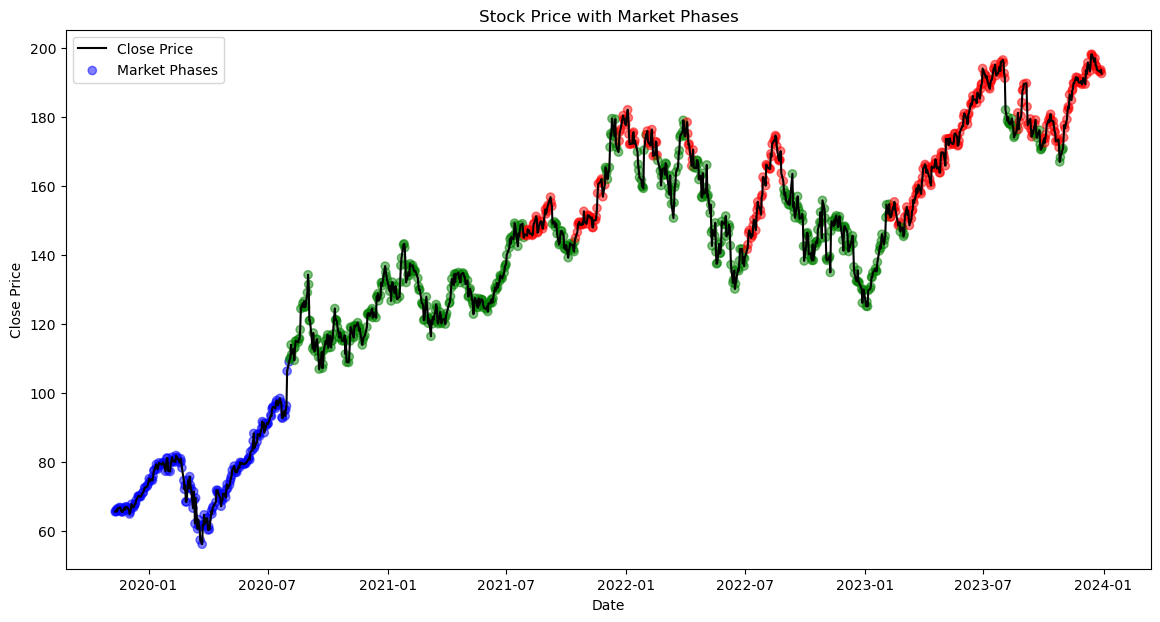

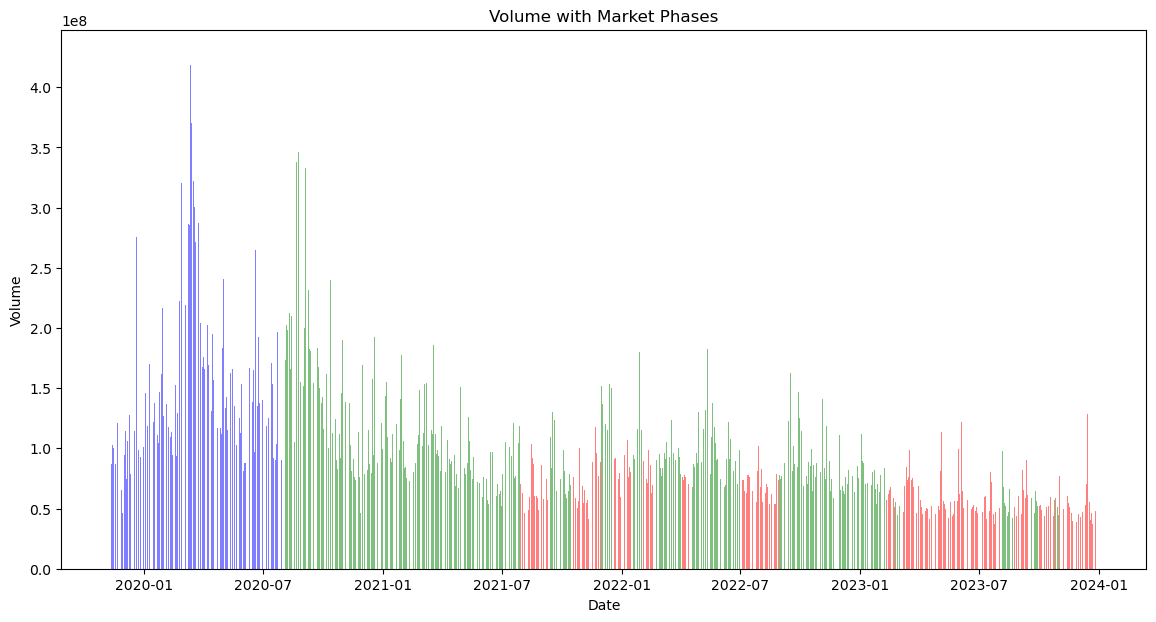

In [47]:
# Example Workflow
ticker = "AAPL"
start_date = "2019-09-01"
end_date = "2024-01-01"

# Load stock data
df = load_stock_data(ticker, start_date, end_date)

# Calculate indicators
df = calculate_indicators(df)

# Prepare data for HMM
features = prepare_hmm_data(df)

# Apply HMM
hidden_states = apply_hmm(features)

# Label market phases
df['Market_Phase'] = hidden_states

# Plotting
plot_stock_with_phases(df)
#plot_pca_with_phases(features[:, :2], hidden_states) 
plot_volume_with_phases(df)

# Defining Strategy Using Backtrader

In [54]:
class RegimeMovingAverageStrategy(bt.Strategy):
    params = (
        ('fast_period', 10),
        ('slow_period', 30),
        ('regime', 'bull'),  # New parameter for market regime
    )

    def __init__(self):
        self.fast_ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.fast_period)
        self.slow_ma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.slow_period)

    def next(self):
        # Only trade if the regime matches
        if self.data._name == self.params.regime:
            if self.fast_ma > self.slow_ma and not self.position:
                self.buy()
            elif self.fast_ma < self.slow_ma and self.position:
                self.sell()

# Backtesting and Optimizing

In [55]:
def backtest_and_optimize(data, hidden_states, fast_periods, slow_periods):
    best_results = []
    
    regimes = np.unique(hidden_states)  # Get unique market phases from HMM
    
    for regime in regimes:
        regime_data = data[data['Market_Phase'] == regime]
        
        for fast_period in fast_periods:
            for slow_period in slow_periods:
                cerebro = bt.Cerebro()
                cerebro.addstrategy(RegimeMovingAverageStrategy, fast_period=fast_period, slow_period=slow_period, regime=regime)
                
                datafeed = bt.feeds.PandasData(dataname=regime_data)
                cerebro.adddata(datafeed)
                
                cerebro.run()
                final_value = cerebro.broker.getvalue()
                
                best_results.append({
                    'Regime': regime,
                    'Color': phase_colors[regime],  # Map regime to color
                    'Fast Period': fast_period,
                    'Slow Period': slow_period,
                    'Final Value': final_value
                })
    
    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(best_results)
    
    # Identify best parameters overall
    best_params = results_df.loc[results_df['Final Value'].idxmax()]
    
    # Identify best parameters for each color (phase)
    best_results_by_color = {}
    for color in phase_colors.values():
        color_df = results_df[results_df['Color'] == color]
        if not color_df.empty:
            best_params_color = color_df.loc[color_df['Final Value'].idxmax()]
            best_results_by_color[color] = best_params_color
    
    return results_df, best_params, best_results_by_color


# Showing Result

In [63]:
phase_colors = {0: 'red', 1: 'green', 2: 'blue', 3:'yellow'}

fast_periods = [5, 10, 15]
slow_periods = [20, 30, 40]

results_df, best_params, best_results_by_color = backtest_and_optimize(df, hidden_states, fast_periods, slow_periods)

print("All Results:")
print(results_df)

print("\nBest Parameters Overall:")
print(best_params)

print("\nBest Results by Color:")
for color, params in best_results_by_color.items():
    print(f"Color: {color}")
    print(params)

All Results:
    Regime  Color  Fast Period  Slow Period  Final Value
0        0    red            5           20      10000.0
1        0    red            5           30      10000.0
2        0    red            5           40      10000.0
3        0    red           10           20      10000.0
4        0    red           10           30      10000.0
5        0    red           10           40      10000.0
6        0    red           15           20      10000.0
7        0    red           15           30      10000.0
8        0    red           15           40      10000.0
9        1  green            5           20      10000.0
10       1  green            5           30      10000.0
11       1  green            5           40      10000.0
12       1  green           10           20      10000.0
13       1  green           10           30      10000.0
14       1  green           10           40      10000.0
15       1  green           15           20      10000.0
16       1  green 